# An analysis of sports activities & wellness reports

> Monitoring Garmin activties.

- toc: false
- badges: false
- comments: true
- use_plotly: true
- categories: [jupyter, garmin, monitoring]

I have a Garmin watch since 2012 (I have already changed 3 times) and the latest, Forerunner 735XT, stores heart rate, number of steps, sleep times... every day. The Garmin [dashboard](https://connect.garmin.com/modern/) is pretty cool but it does not allow to visualize data from (very) long period so, in this notebook, we will have a look on how my wellness and my sport activities have evolved since 2012. By the way, you will not discover any secrets or [military base](https://www.bbc.com/news/technology-42853072), everything is already public and available in my [Garmin profile](https://connect.garmin.com/modern/profile/xavier_garrido).

## Downloading Garmin data

Another limitation of Garmin dashboard is the number of reports/activities that can be exported *via* its interface. Bascially, you have to scroll down to get all the activities since only 25 activities are initially loaded. You can then export the result as `csv` file but you don't have, for instance, the GPS track. There are different ways to download your Garmin data. For instance, you can download the `FIT` files directly from your Garmin watch. You can also use external programs that will grab your data from Garmin websites. I've found at least two `python` programs:
1. [garmin-connect-export](https://github.com/pe-st/garmin-connect-export) will **only** download your Garmin activities and make a nice `csv` report of all your practices. If you don't have or don't care about your daily tracks, this program is largely enough.
2. [GarminDB](https://github.com/tcgoetz/GarminDB) is more complete since it downloads everything. The information is then store within `sqlite` databases that can be pretty huge (few 100 Mb in my case).

Since I don't want to analyse this data every day, I finally choose another way to retrieve the data from Garmin website. I used the official [way](https://www.garmin.com/en-US/account/datamanagement/exportdata/). After unzipping the archive everything gets messed in a nested hierarchical tree with a bunch of empty directories. I "flatten" the archive to only extract the relevant files by doing

```shell
unzip -j -o garmin_data.zip -d data
```

Now we can start to dig into the different files. In this post, I will only read the `json` files to get a good overview of my sports and daily activities. I will not parse the `FIT` files but you can use the [Software Development Kit](https://developer.garmin.com/fit/overview/) made by Garmin and for instance, you can convert your `FIT` files into `csv` by doing

```shell
java -jar FitCSVTool.jar -b activity.fit activity.csv
```
You can also use `python` parser such as [`python-fitparse`](https://github.com/dtcooper/python-fitparse) or [`fitdecode`](https://github.com/polyvertex/fitdecode) (there might be other ones). 

## Preamble & plot settings

We will mainly use [`pandas`](https://pandas.pydata.org) library to handle the data files and [`plotly`](https://plotly.com/python) + [`seaborn`](https://seaborn.pydata.org) libraries for plotting purposes.

In [2]:
import glob

import numpy as np
import pandas as pd
import seaborn as sns


def get_plot_settings(kind="scatter", opacity=0.5, trendline="lowess", frac=0.1):
    settings = dict(template="seaborn", kind=kind, opacity=opacity)

    if kind == "scatter":
        settings.update(
            {
                "trendline": trendline,
                "trendline_options": dict(frac=frac) if trendline == "lowess" else None,
            }
        )
    return settings


pd.options.plotting.backend = "plotly"

## Wellness

We will start by looking into wellness information such as the resting heart rate or the number of steps per day. These informations are stored within `UDSFile*.json` files. We will also merge these data with the sleep time informations whose are stored within `*sleepData.json` files. Let's concatenate all of them after haing indexed them by calendar date.

In [3]:
left = pd.concat([pd.read_json(fn) for fn in glob.glob("data/UDS*.json")])
left.set_index(
    pd.to_datetime(left["restingHeartRateTimestamp"]).dt.normalize().rename("date"),
    inplace=True,
)
right = pd.concat([pd.read_json(fn) for fn in glob.glob("./data/*sleep*.json")])
right.set_index(
    pd.to_datetime(right["calendarDate"]).dt.normalize().rename("date"), inplace=True
)
df = pd.merge(left, right, left_index=True, right_index=True)

### Heart rate monitoring

First, we will have a look to heart rates. 

In [4]:
fields = ["restingHeartRate", "minHeartRate", "maxHeartRate"]
df[fields].describe()

restingHeartRate  minHeartRate  maxHeartRate
count       1136.000000   1136.000000   1136.000000
mean          50.309859     43.418134    141.169894
std            2.688027      3.590539     23.592656
min           37.000000     30.000000     87.000000
25%           48.000000     41.000000    123.000000
50%           50.000000     44.000000    138.000000
75%           52.000000     46.000000    160.000000
max           58.000000     53.000000    204.000000

We will plot the min/max and resting heart rate versus the time. To better follow the time variation of each curves, I have also added a `lowess` (Locally Weighted Scatterplot Smoothing) trendline.

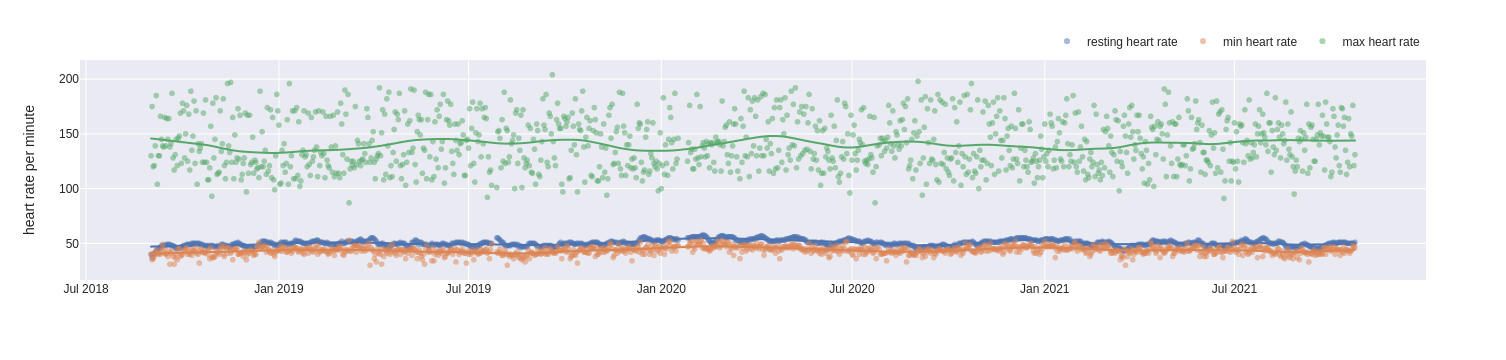

In [5]:
df[fields].rename(
    columns={
        field: "".join(f" {c.lower()}" if c.isupper() else c for c in field)
        for field in fields
    }
).plot(
    labels={"value": "heart rate per minute", "variable": "", "date": ""},
    **get_plot_settings(),
).update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

Basically, during summer and beginning of autumn when I do a lot of sports, the resting heart as well as the minimum heart rate (both completely correlated) decrease and then increase during the winter time. We will see latter if we can correlate these time variations with the number of activities per day.

### Number of steps per day

Let's now have a look to the number of steps done by day. Garmin dashboard allow to see them but not on period larger than 1 year. Here we also add the daily step goal for comparison purpose (orange curve).

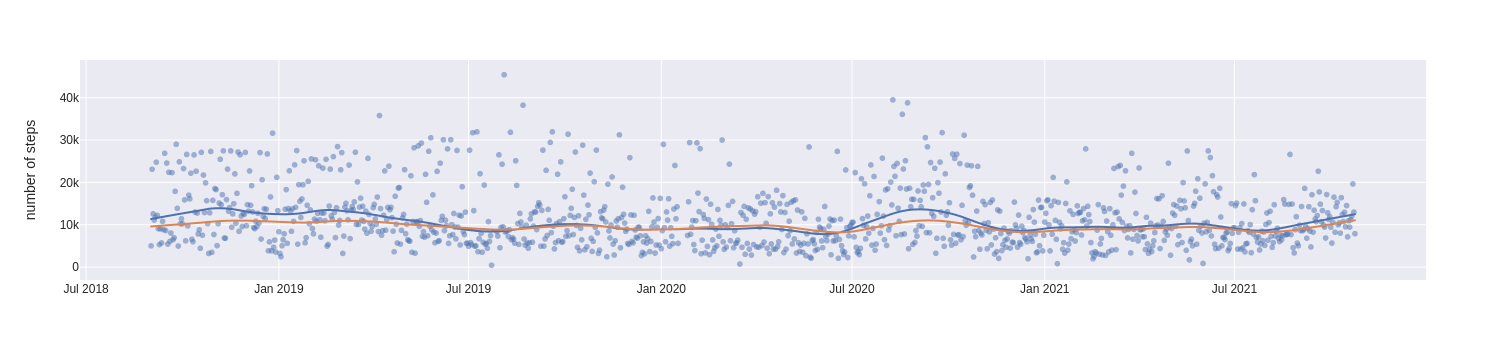

In [6]:
df[["totalSteps", "dailyStepGoal"]].plot(
    labels={"date": "", "value": "number of steps"}, **get_plot_settings()
).update_layout(showlegend=False).update_traces(
    selector=-2, opacity=0, hovertemplate=None, hoverinfo="skip"
)

Just like the resting heart rate, we clearly see a bump in the 2020 summer when I actually did a lot of sport activities especially trail competitions. The software which updates the daily step goal given the number of steps achieved is pretty good in the sense that I have overcome the goal almost 50% of the time

In [7]:
(df.totalSteps > df.dailyStepGoal).sum() / len(df.dailyStepGoal)

0.5369718309859155

### Sleep times

I also keep my watch during the night to monitor my sleep times. The total amount of sleep time is not provided, so let's add it by summing the different sleep status : awake, light and deep sleep

In [8]:
fields = [
    "deepSleepSeconds",
    "lightSleepSeconds",
    "awakeSleepSeconds",
    "totalSleepSeconds",
]
df["totalSleepSeconds"] = df[fields[:-1]].dropna().sum(axis=1)
df[fields].div(3600).describe()

deepSleepSeconds  lightSleepSeconds  awakeSleepSeconds  \
count       1129.000000        1129.000000        1129.000000   
mean           2.322601           4.712002           0.166800   
std            0.724116           1.028293           0.187822   
min            0.000000           0.000000           0.000000   
25%            1.883333           4.100000           0.066667   
50%            2.300000           4.716667           0.116667   
75%            2.766667           5.400000           0.216667   
max            6.166667           8.150000           1.716667   

       totalSleepSeconds  
count        1129.000000  
mean            7.201402  
std             1.201655  
min             0.000000  
25%             6.583333  
50%             7.266667  
75%             7.950000  
max            10.333333

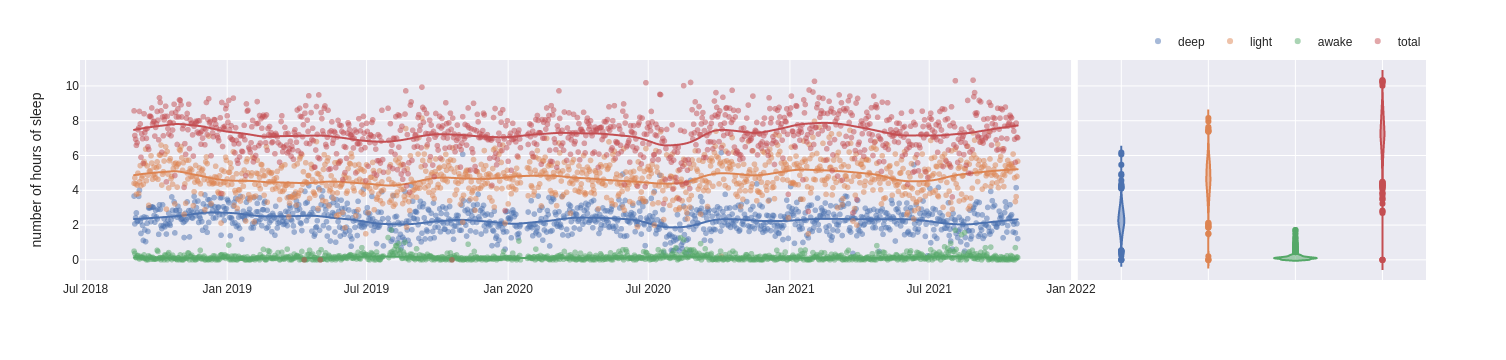

In [9]:
df[fields].div(3600).rename(
    columns={field: field.replace("SleepSeconds", "") for field in fields}
).plot(
    labels={"value": "number of hours of sleep", "variable": "", "date": ""},
    **get_plot_settings(),
    marginal_y="violin"
).update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

Interestingly, there are 3 days for which I do not sleep at all. Let's have a look on what's going on 

In [10]:
df[df["totalSleepSeconds"] == 0][["sleepWindowConfirmationType"]]

sleepWindowConfirmationType
date                                  
2019-04-11                   OFF_WRIST
2019-05-02                   OFF_WRIST
2019-10-20                   OFF_WRIST

As far as I can understand, on a total of 1129 nights, I have only slept 3 nights without my watch. I'm a bit surprised by how low this number is but it is what it is. Finally let's study the total number of hours I sleep per day; for instance, let's compare it to its mean and its standard deviation 

In [11]:
total_sleep_hours = df.totalSleepSeconds.div(3600)
mean, std = total_sleep_hours.mean(), total_sleep_hours.std()
total_sleep_hours.plot(
    labels={"value": "number of hours of sleep", "variable": "", "date": ""},
    **get_plot_settings(),
).update_layout(showlegend=False).add_hrect(
    y0=mean - std, y1=mean + std, line_width=0, fillcolor="red", opacity=0.2
)

It looks pretty stable over time. There is a slight decrease in August, 2020 when I was practicing sports arly in the day (sun in Spain is pretty hot). 

In [12]:
(total_sleep_hours > mean).sum() / len(total_sleep_hours)

0.5211267605633803

In [13]:
((total_sleep_hours - mean).abs() < std).sum() / len(total_sleep_hours)

0.7183098591549296

As the violin plot shown before, the distribution is quite gaussian with 71% of the nights within mean ± 1σ (68% for normal distribution). Last, let's have a look to my sleeping times by day and by month.

In [14]:
import calendar

by_day = total_sleep_hours.groupby(total_sleep_hours.index.day_of_week)
by_day.mean().plot(
    error_y=by_day.std() / np.sqrt(by_day.count()),
    **get_plot_settings(),
    labels={"value": "number of hours of sleep", "variable": "", "date": ""},
).update_layout(
    showlegend=False,
    xaxis=dict(
        tickmode="array", tickvals=list(range(7)), ticktext=list(calendar.day_abbr)
    ),
)

In [15]:
by_month = total_sleep_hours.groupby(total_sleep_hours.index.month)
by_month.mean().plot(
    error_y=by_month.std() / np.sqrt(by_month.count()),
    **get_plot_settings(),
    labels={"value": "number of hours of sleep", "variable": "", "date": ""},
).update_layout(
    showlegend=False,
    xaxis=dict(
        tickmode="array", tickvals=list(range(13)), ticktext=list(calendar.month_abbr)
    ),
)

Here again, the summer is when I sleep less since it's holiday time. I also sleep more during week-end as most of the normal people I guess.

### Correlation plot

There might be a lot more to do with these data; I basically have looked to obvious plots. I haven't tried to correlate things together

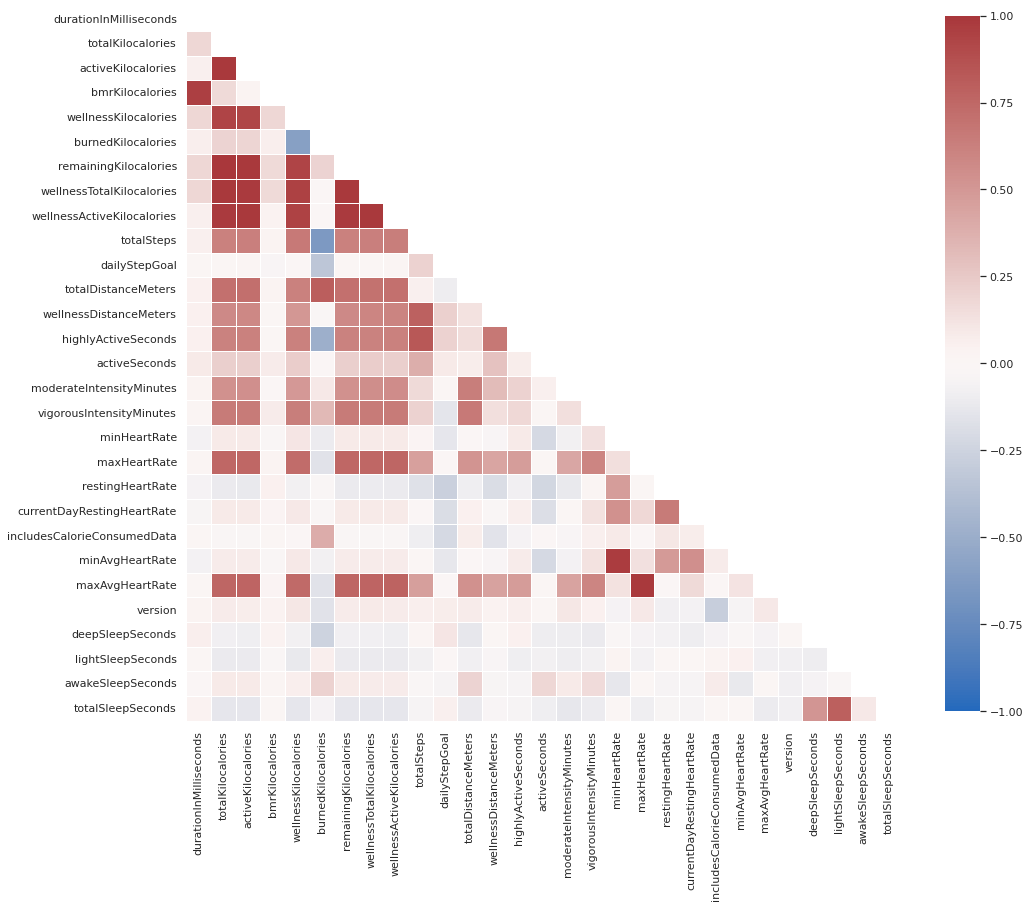

In [16]:
corr = df.corr().dropna(axis=0, how="all").dropna(axis=1, how="all")

sns.set(rc={"figure.figsize": (16, 16)})
with sns.axes_style("whitegrid"):
    sns.heatmap(
        corr,
        mask=np.triu(np.ones_like(corr, dtype=bool)),
        cmap="vlag",
        vmax=+1,
        vmin=-1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )

There are clearly columns with somewhat identical informations under different names. There are also correlation between the calories burn and the heart activities, especially the maximum heart value which is an indicator of the activity level.

In [17]:
with pd.option_context("display.max_rows", 100):
    display(
        corr[corr.abs() > 0.75]
        .unstack()
        .dropna()
        .sort_values(ascending=False)
        .drop_duplicates()
        .to_frame(name="correlation")
    )

correlation
durationInMilliseconds     durationInMilliseconds         1.000000
wellnessTotalKilocalories  totalKilocalories              0.992182
activeKilocalories         wellnessActiveKilocalories     0.991973
                           remainingKilocalories          0.991727
wellnessActiveKilocalories wellnessTotalKilocalories      0.991500
maxAvgHeartRate            maxHeartRate                   0.985582
wellnessActiveKilocalories remainingKilocalories          0.983995
activeKilocalories         wellnessTotalKilocalories      0.983391
minAvgHeartRate            minHeartRate                   0.975057
bmrKilocalories            durationInMilliseconds         0.953503
wellnessTotalKilocalories  wellnessKilocalories           0.952172
wellnessKilocalories       wellnessActiveKilocalories     0.941030
remainingKilocalories      wellnessKilocalories           0.936570
wellnessKilocalories       totalKilocalories              0.936570
activeKilocalories         wellnessKilocalories           0.925083
totalSteps                 highlyActiveSeconds            0.831995
totalDistanceMeters        burnedKilocalories             0.800552
lightSleepSeconds          totalSleepSeconds              0.792100
totalSteps                 wellnessDistanceMeters         0.788607
maxAvgHeartRate            wellnessActiveKilocalories     0.774520
                           activeKilocalories             0.770225
wellnessTotalKilocalories  maxAvgHeartRate                0.767150
totalKilocalories          maxAvgHeartRate                0.763245
wellnessActiveKilocalories maxHeartRate                   0.760031
maxHeartRate               activeKilocalories             0.756199
wellnessTotalKilocalories  maxHeartRate                   0.753899
remainingKilocalories      maxHeartRate                   0.750429

## Sport activities

We will now have a look to the sport activities. I firstly use my Garmin devices for running but, since I'm getting older, I now practice swimming. I also do cycling since I go to the University and laboratory in bike almost everyday (or I try to do that). As I wrote before I won't dig into the `FIT` files. I will analyze the summarized informations provided by Garmin reports. 

In [18]:
import json

df = pd.concat(
    [
        pd.json_normalize(json.load(open(fn)), record_path="summarizedActivitiesExport")
        for fn in glob.glob("data/*_summarizedActivities.json")
    ]
)
df.sportType = df.sportType.str.lower().fillna("undefined")
df.duration = pd.to_timedelta(df.duration, unit="ms").astype("timedelta64[s]") / 3600
df.distance /= 100

df.set_index(
    pd.to_datetime(df["beginTimestamp"], unit="ms").rename("date"),
    inplace=True,
)
df.sort_index(inplace=True)

The activity type can be translated into a more informal value using Garmin correspondance [scheme](https://connect.garmin.com/modern/main/js/properties/activity_types/activity_types.properties)

In [19]:
import requests

url = "https://connect.garmin.com/modern/main/js/properties/activity_types/activity_types.properties"
activity_types = dict(
    line.replace("activity_type_", "").split("=")
    for line in requests.get(url).text.split("\n")[:-1]
)

df.activityType = df.activityType.map(activity_types)

In the `pandas` dataframe, some other informations are missing such as gear's name of VO2 information. We can find them other files and we will add them to the dataframe object.

In [20]:
gears = json.load(open("data/xavier_garrido_gear.json"))[0]
gear_names = {
    gear.get("gearPk"): gear.get("customMakeModel") for gear in gears.get("gearDTOS")
}
gears = {
    activity.get("activityId"): gear_names.get(int(gear_id))
    for gear_id, info in gears.get("gearActivityDTOs").items()
    for activity in info
}

vo2max = {
    d.get("activityId"): d.get("vo2MaxValue")
    for fn in glob.glob("data/ActivityVo2Max_*.json")
    for d in json.load(open(fn))
}

for k, v in {"gear": gears, "vo2max": vo2max}.items():
    df[k] = df.activityId.apply(lambda a: v.get(a))

### Activity & sport type

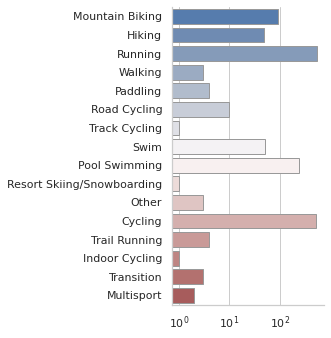

In [21]:
catplot_kwargs = dict(kind="count", edgecolor="0.6", palette="vlag")
set_kwargs = dict(xscale="log", xlabel="", ylabel="")

with sns.axes_style("whitegrid"):
    sns.catplot(y="activityType", data=df, **catplot_kwargs).set(**set_kwargs);

I did skiing only one time 

In [22]:
df[df.activityType.str.contains("Skiing")][["name"]]

name
date                              
2015-01-15 14:22:39  Aussois - Ski

and I really didn't like it... Otherwise, my main activities are running, swimming and cycling.

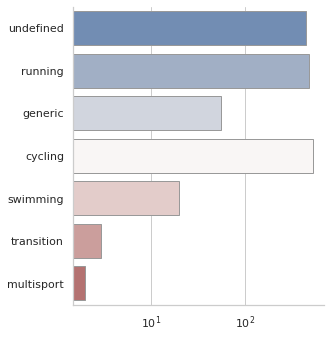

In [23]:
with sns.axes_style("whitegrid"):
    sns.catplot(y="sportType", data=df, **catplot_kwargs).set(**set_kwargs);

I guess `transition` and `multisport` activities are some triathlon I did last year

In [24]:
df[df.sportType.isin(["transition", "multisport"])][["name"]]

name
date                                                                  
2021-08-01 09:49:31  XII Triatlo Popular Portocolom 2021 - Transiti...
2021-08-01 10:09:15  XII Triatlo Popular Portocolom 2021 - Transiti...
2021-08-08 07:05:02                  V AquaRun Basiliscus - Transition
NaT                                               V AquaRun Basiliscus
NaT                                XII Triatlo Popular Portocolom 2021

There are also a large fraction of activities which are `undefined` or `generic`. Let's plot the activity type related to these sport types

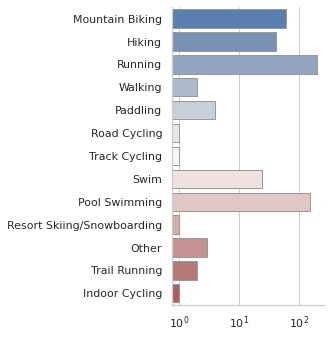

In [25]:
unkown_sports = df.sportType.isin(["generic", "undefined"])
with sns.axes_style("whitegrid"):
    sns.catplot(y="activityType", data=df[unkown_sports], **catplot_kwargs).set(
        **set_kwargs
    );

We will reassign the sport type given the activity type

In [26]:
def change_sport_type(activity):
    sport_type = None
    if "Swim" in activity:
        sport_type = "swimming"
    if "Running" in activity:
        sport_type = "running"
    if "Cycling" in activity or "Biking" in activity:
        sport_type = "cycling"
    return sport_type


df["sportType"] = df["activityType"].map(change_sport_type)

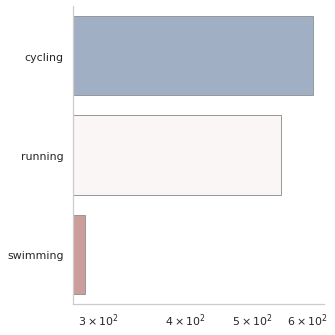

In [27]:
with sns.axes_style("whitegrid"):
    sns.catplot(y="sportType", data=df, **catplot_kwargs).set(**set_kwargs);

Now we can plot the time variation of the number of activity per month and per sport

In [28]:
sports = ["running", "cycling", "swimming"]

sport_activities = df[df.sportType.isin(sports)]
sport_counts = (
    sport_activities.groupby(["sportType", sport_activities.index])
    .count()
    .activityType.unstack()
    .T.resample("m")
    .count()
)

fig = (
    pd.melt(sport_counts.reset_index(), id_vars="date", value_vars=sports)
    .plot(
        x="date",
        y="value",
        facet_row="sportType",
        labels={"date": ""},
        **get_plot_settings(kind="bar")
    )
    .update_yaxes(matches=None)
    .update_layout(height=800)
    .for_each_annotation(lambda a: a.update(text=""))
)
for i, sport in enumerate(sports[::-1]):
    fig.update_yaxes(title_text=sport, row=i + 1)
fig

When I have started cycling, my running activities have been slowly but surely declining. My swimming activities were quite important when I was preparing the ["défi de Monte Cristo"](https://www.defimonte-cristo.com)

In [29]:
df[df.name.str.contains("Monte")][["name", "distance", "duration"]]

name     distance  \
date                                                                       
2015-06-21 08:33:32  Marseille - Défi de Monte-Christo 2015  6402.120000   
2017-06-23 07:42:12  Marseille - Défi de Monte-Christo 2017  6373.149902   

                     duration  
date                           
2015-06-21 08:33:32  1.451667  
2017-06-23 07:42:12  1.449722

### Running activities

I will now dig into my running activities. First, I will plot the shoes distribution.

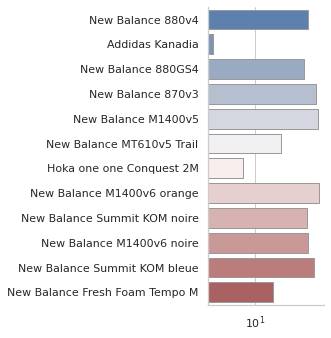

In [55]:
running_activities = df[df.sportType == "running"]

with sns.axes_style("whitegrid"):
    sns.catplot(y="gear", data=running_activities, **catplot_kwargs).set(**set_kwargs);

Of cours, New Balance shoes are the one I used since they offer a larger width and I know precisely which size I need (so I can for instance order them on internet during sales). I have tried Hoka one one but I have quickly resigned.

We can now plot the relationship between the distance I run and the time it takes

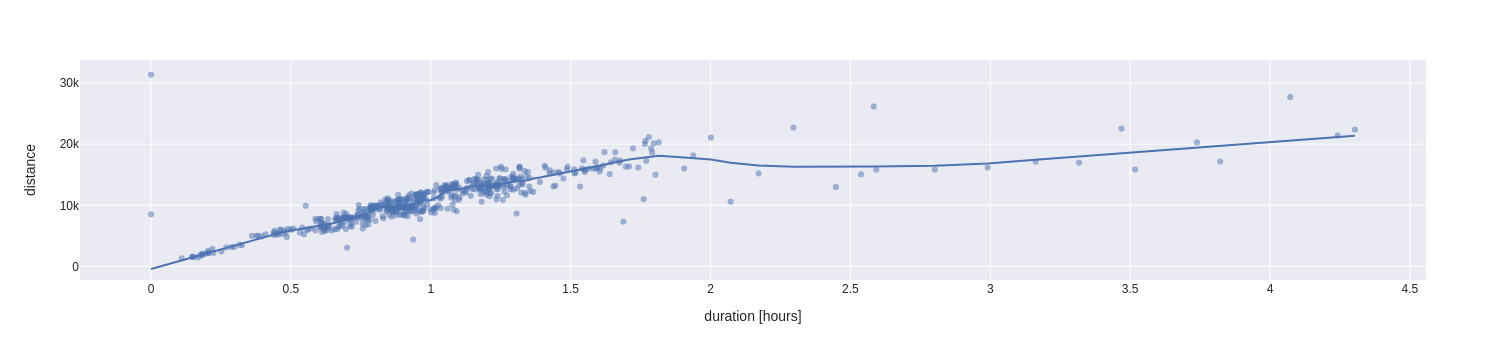

In [56]:
running_activities.plot(
    x="duration",
    y="distance",
    labels={"duration": "duration [hours]"},
    **get_plot_settings()
)

In [31]:
fields = ["avgHr", "distance", "duration"]
fig = (
    pd.melt(running_activities.reset_index(), id_vars="date", value_vars=fields)
    .plot(
        x="date",
        y="value",
        facet_row="variable",
        labels={"date": ""},
        **get_plot_settings()
    )
    .update_yaxes(matches=None)
    .update_layout(height=800)
    .for_each_annotation(lambda a: a.update(text=""))
    .update_traces(hovertemplate=None, hoverinfo="skip", selector=dict(mode="lines"))
)

for i, ylabel in enumerate(
    ["duration [hours]", "distance [m]", "mean heart rate [per min.]"]
):
    fig.update_yaxes(title_text=ylabel, row=i + 1)
fig

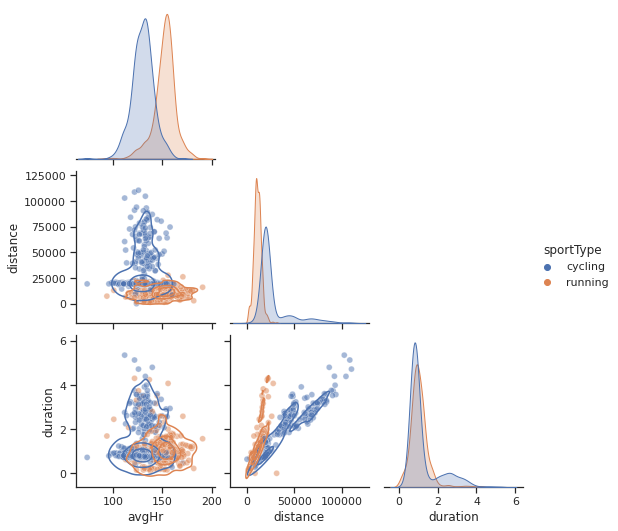

In [32]:
with sns.axes_style("ticks", rc={"figure.figsize": (16, 16)}):
    sns.pairplot(
        data=df[df.sportType.isin(["cycling", "running"])],
        vars=fields,
        corner=True,
        diag_kind="kde",
        hue="sportType",
        plot_kws=dict(alpha=0.5),
    ).map_lower(sns.kdeplot, levels=4)

## Addendum: parsing `FIT` files 

In [36]:
%pip install fitdecode

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [62]:
import os

import fitdecode
from tqdm.auto import trange

cache_dir = "cache"
cache_file = os.path.join(cache_dir, "locations.csv")
os.makedirs(cache_dir, exist_ok=True)

if os.path.exists(cache_file):
    print(f"Read from {cache_file}")
    locations = pd.read_csv(cache_file)
else:

    activities = []

    files = glob.glob("data/fit_files/*.fit")
    for i in trange(len(files)):
        try:
            with fitdecode.FitReader(
                files[i], check_crc=fitdecode.CrcCheck.DISABLED
            ) as fit:
                sport, lat, long = None, [], []
                for frame in fit:
                    if isinstance(frame, fitdecode.FitDataMessage):
                        lat += frame.get_values("position_lat")
                        long += frame.get_values("position_long")
                        sport = frame.get_value("sport", fallback=None) or sport
                if sport in sports:
                    activities += [
                        list(location) + [sport] for location in zip(lat, long)
                    ]
        except fitdecode.exceptions.FitEOFError:
            pass
    locations = (
        pd.DataFrame.from_records(
            activities, index="activity", columns=["latitude", "longitude", "activity"]
        )
        .div(2 ** 32 / 360)
        .dropna()
    )
    locations.to_csv(cache_file)

  0%|          | 0/8216 [00:00<?, ?it/s]

In [63]:
from ipyleaflet import FullScreenControl, Heatmap, Map, WidgetControl, basemaps
from ipywidgets import RadioButtons

m = Map(
    basemap=basemaps.OpenStreetMap.BlackAndWhite,
    center=locations.mean().tolist(),
    zoom=4,
    scroll_wheel_zoom=True,
    controls=[FullScreenControl()],
)

cmap = sns.color_palette("flare", as_cmap=True)
heat = Heatmap(
    locations=locations.loc["running"].values.tolist(),
    radius=10,
    gradient={
        frac: "#" + "".join(format(int(255 * x), "02x") for x in cmap(frac)[:-1])
        for frac in np.arange(0, 1, 0.1)
    },
)
m.add_layer(heat)


def update_activity(change):
    heat.locations = locations.loc[change["new"]].values.tolist()


radiobuttons = RadioButtons(options=sports, value="running", description="Sport")
radiobuttons.observe(update_activity, "value")
m.add_control(
    WidgetControl(
        widget=radiobuttons, position="bottomleft", max_width=220, max_height=75
    )
)

m

Map(center=[46.738558235209084, 1.6704874301734498], controls=(FullScreenControl(options=['position']), ZoomCo…